# Init

In [1]:
import cv2 as cv
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import skimage
import sklearn.cluster

In [2]:
sns.set(style='dark')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['image.cmap'] = 'viridis'
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

In [5]:
rgb = skimage.io.imread('robot.bmp')
rgb = skimage.util.img_as_float(rgb)
rgb.shape, rgb.dtype, rgb.min(), rgb.max()

((234, 160, 3), dtype('float64'), 0.0, 1.0)

In [6]:
gray = skimage.color.rgb2gray(rgb)
gray.shape, gray.dtype, gray.min(), gray.max()

((234, 160), dtype('float64'), 0.0, 1.0)

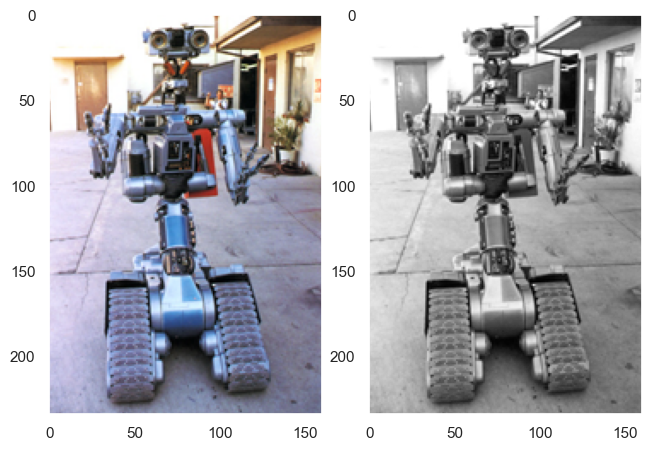

In [7]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb)
axes[1].imshow(gray, cmap='gray', vmin=0., vmax=1.);

# Edges as gradient

Edges correspond to changes in brightness and can be enhanced by computing derivatives. See the following figure, in which
$$
f'(x) = \frac{\textrm{d}f(x)}{\textrm{d}x}
$$

<img src="figures/edges_hough-derivative.png" alt="Interpolation" style="width: 6.4in;"/>

Since we're dealing with discrete functions, we can only approximate derivatives using differences. Most commonly, central symmetric difference is used:
$$
\frac{\textrm{d}f(x)}{\textrm{d}x} \approx \frac{ f(x+1)-f(x-1) }{ 2 }
$$

## First some simple 1D example

In [8]:
x = np.linspace(-10., 10., 21)  # e.g. time
f = 1 / (1 + np.exp(-x))  # value of function in time
f.shape, f.dtype

((21,), dtype('float64'))

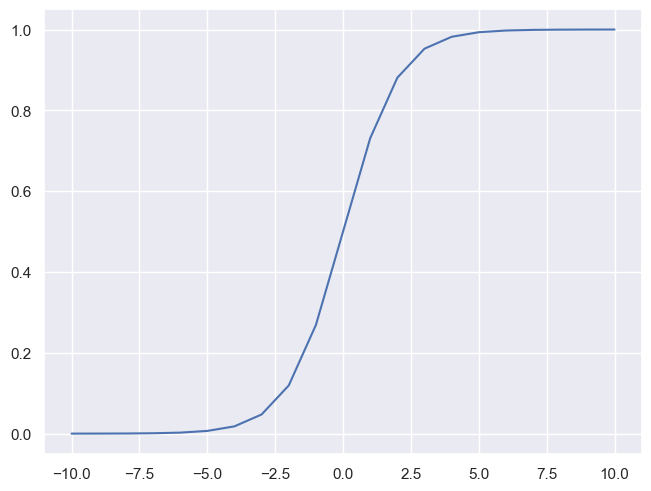

In [9]:
plt.plot(x, f);
plt.grid();

In [10]:
f

array([0.   , 0.   , 0.   , 0.001, 0.002, 0.007, 0.018, 0.047, 0.119, 0.269, ..., 0.731, 0.881, 0.953, 0.982, 0.993, 0.998, 0.999, 1.   ,
       1.   , 1.   ])

In [11]:
f[2:]

array([0.   , 0.001, 0.002, 0.007, 0.018, 0.047, 0.119, 0.269, 0.5  , 0.731, 0.881, 0.953, 0.982, 0.993, 0.998, 0.999, 1.   , 1.   , 1.   ])

In [12]:
f[:-2]

array([0.   , 0.   , 0.   , 0.001, 0.002, 0.007, 0.018, 0.047, 0.119, 0.269, 0.5  , 0.731, 0.881, 0.953, 0.982, 0.993, 0.998, 0.999, 1.   ])

In [13]:
df = np.zeros_like(f)
df[1:-1] = (f[2:] - f[:-2]) / 2
df[0] = df[1]
df[-1] = df[-2]
df

array([0.   , 0.   , 0.   , 0.001, 0.003, 0.008, 0.02 , 0.051, 0.111, 0.19 , ..., 0.19 , 0.111, 0.051, 0.02 , 0.008, 0.003, 0.001, 0.   ,
       0.   , 0.   ])

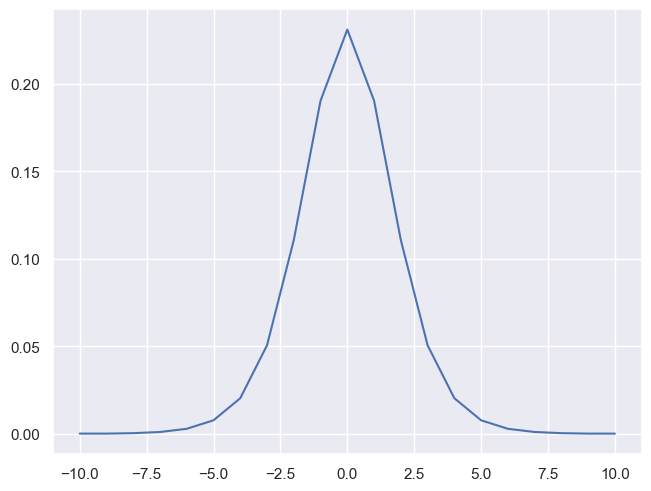

In [14]:
plt.plot(x, df);
plt.grid();

In [15]:
# position of the max, i.e. the location of the edge
x[np.argmax(df)]

0.0

## 2D example

When in 2D, we need to compute the derivatives along all dimensions (axes) of our input, i.e. for both $x$ and $y$:
$$
I_x(x,y) = \frac{ \partial I(x,y) } { \partial x }, \qquad I_y(x, y) = \frac{ \partial I(x,y) } { \partial y }
$$

In [16]:
# generate super-gaussian function
y, x = np.mgrid[-3:3.1:0.1,-3:3.1:0.1]
s, p = 2, 1
f = np.exp(-0.5 * ((x**2 + y**2) / s) ** (2*p))
f.shape, f.dtype, f.min(), f.max()

((61, 61), dtype('float64'), 2.576757109154981e-18, 1.0)

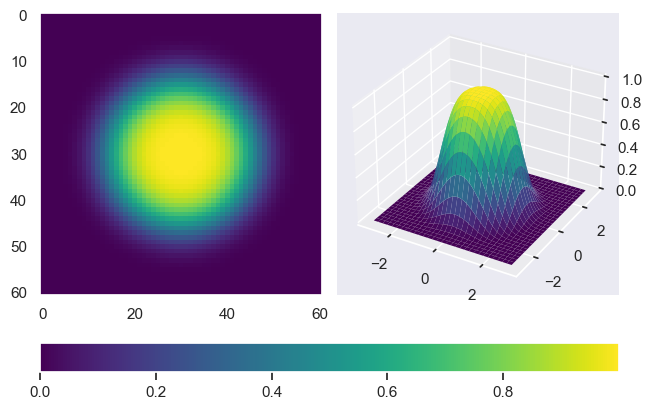

In [17]:
fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1)
im = ax0.imshow(f)
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
sf = ax1.plot_surface(x, y, f, cmap=plt.rcParams['image.cmap'], linewidth=0);
fig.colorbar(sf, ax=[ax0, ax1], location='bottom');

In [18]:
f_dx = np.zeros_like(f)
f_dy = np.zeros_like(f)
f_dx[:, 1:-1] = 0.5 * (f[:, 2:] - f[:, :-2])
f_dy[1:-1, :] = 0.5 * (f[2:, :] - f[:-2, :])

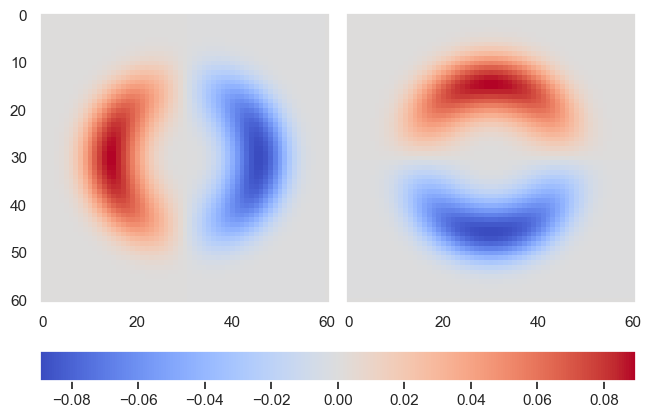

In [19]:
fig, axes = plt.subplots(1, 2, sharey=True)
im0 = axes[0].imshow(f_dx, cmap='coolwarm')
im1 = axes[1].imshow(f_dy, cmap='coolwarm')
fig.colorbar(im1, ax=axes, location='bottom');

## Using `numpy.gradient`

In [20]:
f_dy, f_dx = np.gradient(f)
f_dx.shape, f_dy.shape

((61, 61), (61, 61))

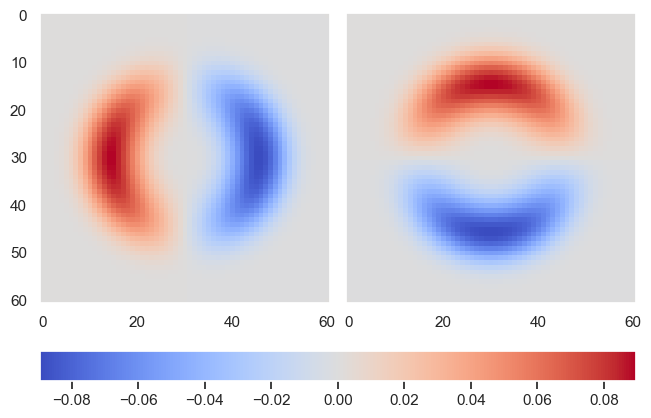

In [21]:
fig, axes = plt.subplots(1, 2, sharey=True)
im0 = axes[0].imshow(f_dx, cmap='coolwarm')
im1 = axes[1].imshow(f_dy, cmap='coolwarm')
fig.colorbar(im1, ax=axes, location='bottom');

## Gradient magnitude

We may organize the partial derivatives into a vector called the **gradient**:
$$
\nabla I(x,y) = \begin{bmatrix}
    I_x(x,y) \\
    I_y(x,y)
\end{bmatrix}
$$

The **magnitude** of the gradient is defined as an $L_2$ norm of the gradient vector, i.e.
$$
\left| \nabla I \right| = \sqrt{I_x^2 + I_y^2}
$$

The magnitude is invariant to image rotations.

In [22]:
df_mag = np.sqrt(f_dx ** 2 + f_dy ** 2)

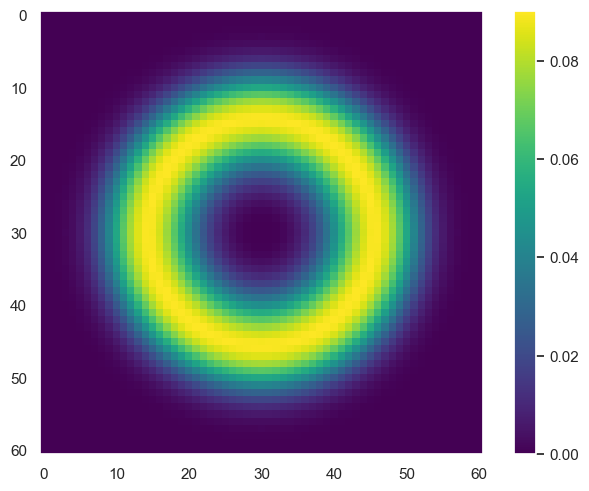

In [23]:
plt.imshow(df_mag);
plt.colorbar();

# Gradient-based edge detections via convolution

We may treat the gradient computation as a convolution with derivative filters. For $x$ and $y$ directions, respectively, the filters are
$$
h_x = \begin{bmatrix}
    0.5 & 0 & -0.5
\end{bmatrix},
\qquad
h_y = \begin{bmatrix}
     0.5 \\
     0 \\
    -0.5
\end{bmatrix}
$$

Notice the reverse signs - this is because before convolution means correlating with horizontally and vertically flipped filters.

In [24]:
h_dx = 0.5 * np.array([
    [1, 0, -1]
])
h_dx

array([[ 0.5,  0. , -0.5]])

In [25]:
h_dy = h_dx.T
h_dy

array([[ 0.5],
       [ 0. ],
       [-0.5]])

In [26]:
f_dx = scipy.ndimage.convolve(f, h_dx)
f_dy = scipy.ndimage.convolve(f, h_dy)
df_mag = np.sqrt(f_dx ** 2 + f_dy ** 2)

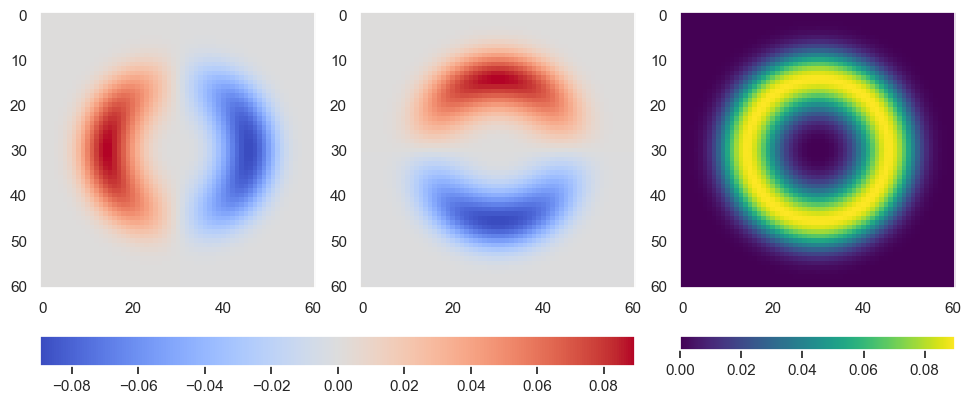

In [27]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.5))
im0 = axes[0].imshow(f_dx, cmap='coolwarm')
im1 = axes[1].imshow(f_dy, cmap='coolwarm')
fig.colorbar(im1, ax=axes[:2], location='bottom');
im2 = axes[2].imshow(df_mag);
fig.colorbar(im2, ax=axes[2:], location='bottom');

## Common edge detection kernels

Usually, edge detection kernels operate over a small neighborhood around each pixel in order to increase robustness against noise. Some examples are:
- Roberts
- Prewitt
- Sobel
- Improved Sobel

In [28]:
edge_kernels = {
    'roberts_x': np.array([
        [0., 1.],
        [-1., 0.],
    ]),
    'roberts_y': np.array([
        [-1., 0.],
        [0., 1.],
    ]),
    'prewitt_x': np.array([
        [-1., 0., 1.],
        [-1., 0., 1.],
        [-1., 0., 1.],
    ]),
    'prewitt_y': np.array([
        [-1., -1., -1.],
        [0.,  0.,  0. ],
        [1.,  1.,  1. ],
    ]),
    'sobel_x': np.array([
        [-1., 0., 1.],
        [-2., 0., 2.],
        [-1., 0., 1.],
    ]),
    'sobel_y': np.array([
        [-1., -2., -1.],
        [0.,  0.,  0. ],
        [1.,  2.,  1. ],
    ]),
    'improved_sobel_x': 1./32. * np.array([
        [-3., 0., 3.],
        [-10., 0., 10.],
        [-3., 0., 3.],
    ]),
    'improved_sobel_y': 1./32. * np.array([
        [-3., -10., -3.],
        [0.,  0.,  0. ],
        [3.,  10.,  3. ],
    ]),
}

In [29]:
gray_convs = {
    name: scipy.ndimage.convolve(gray, kernel)
    for name, kernel in edge_kernels.items()
}

In [30]:
gray_grad_mags = {
    name: (gray_convs[f"{name}_x"] ** 2 + gray_convs[f"{name}_y"] ** 2) ** 0.5
    for name in ('roberts', 'prewitt', 'sobel', 'improved_sobel')
}

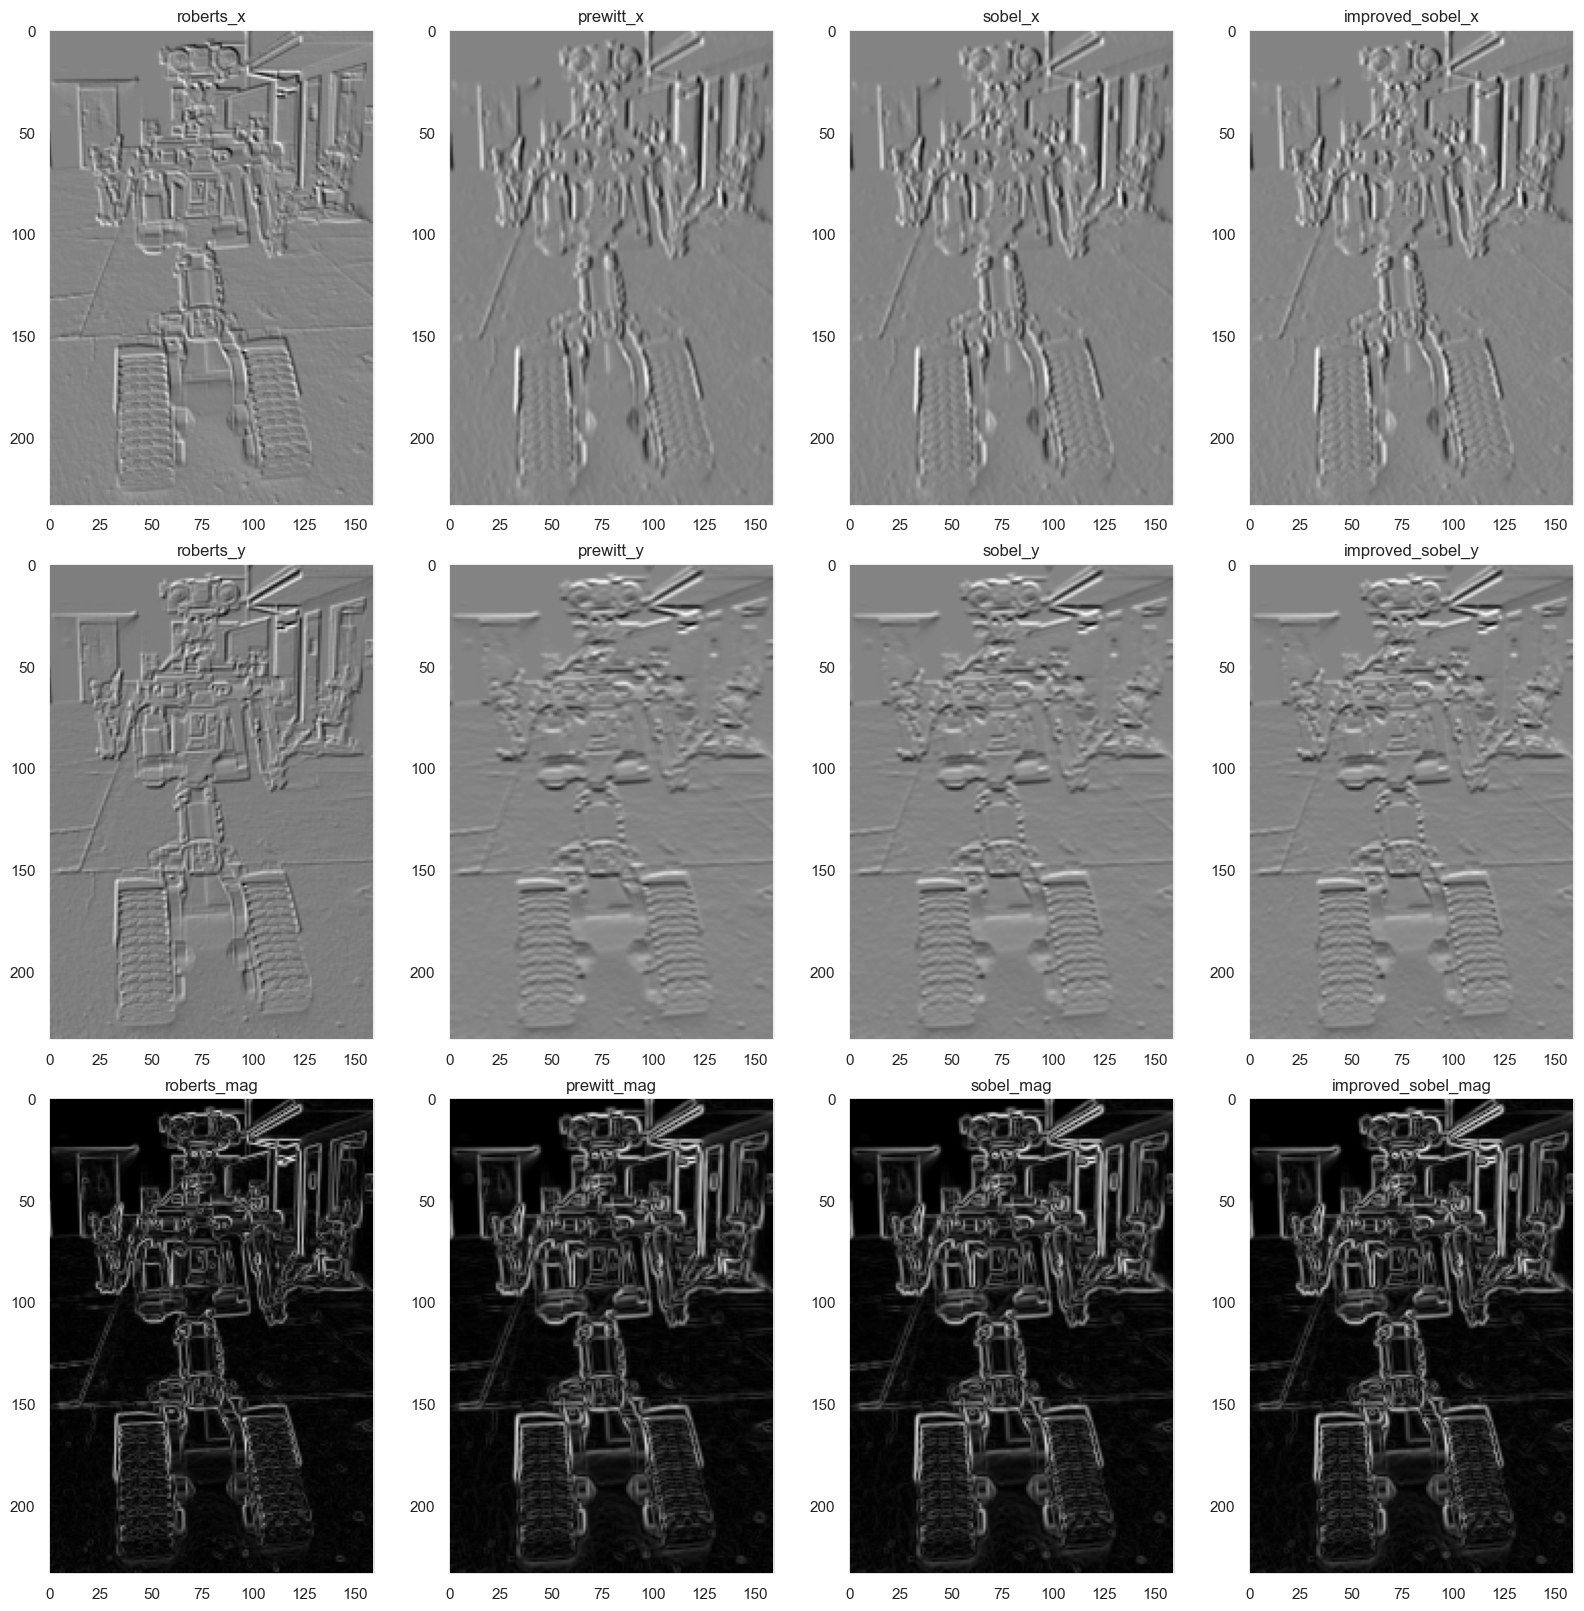

In [31]:
fig, axes = plt.subplots(3, 4, figsize=(16, 16))
for i, name in enumerate(('roberts', 'prewitt', 'sobel', 'improved_sobel')):
    axes.T.flat[3*i].imshow(gray_convs[f"{name}_x"], cmap='gray')
    axes.T.flat[3*i].set_title(f"{name}_x")
    axes.T.flat[3*i+1].imshow(gray_convs[f"{name}_y"], cmap='gray')
    axes.T.flat[3*i+1].set_title(f"{name}_y")
    axes.T.flat[3*i+2].imshow(gray_grad_mags[f"{name}"], cmap='gray')
    axes.T.flat[3*i+2].set_title(f"{name}_mag")


## Compass operators

Compass operators detect edges in several directions and then define the response for each point as the maximum over all directions.

In [32]:
compass_values = {
    'extended_sobel': np.array([1, 2, 1, 0, -1, -2, -1, 0], dtype=float),
    'kirsch': np.array([-5, -5, 3, 3, 3, 3, 3, -5], dtype=float)
}
create_kernel = lambda h: np.array([
    [h[0], h[1], h[2]],
    [h[7],    0, h[3]],
    [h[6], h[5], h[4]]
])
compass_kernels = {
    name: np.array([create_kernel(np.roll(vals, r)) for r in range(8)])
    for name, vals in compass_values.items()
}
compass_kernels

{'extended_sobel': array([[[ 1.,  2.,  1.],
         [ 0.,  0.,  0.],
         [-1., -2., -1.]],
 
        [[ 0.,  1.,  2.],
         [-1.,  0.,  1.],
         [-2., -1.,  0.]],
 
        [[-1.,  0.,  1.],
         [-2.,  0.,  2.],
         [-1.,  0.,  1.]],
 
        [[-2., -1.,  0.],
         [-1.,  0.,  1.],
         [ 0.,  1.,  2.]],
 
        [[-1., -2., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  2.,  1.]],
 
        [[ 0., -1., -2.],
         [ 1.,  0., -1.],
         [ 2.,  1.,  0.]],
 
        [[ 1.,  0., -1.],
         [ 2.,  0., -2.],
         [ 1.,  0., -1.]],
 
        [[ 2.,  1.,  0.],
         [ 1.,  0., -1.],
         [ 0., -1., -2.]]]),
 'kirsch': array([[[-5., -5.,  3.],
         [-5.,  0.,  3.],
         [ 3.,  3.,  3.]],
 
        [[-5., -5., -5.],
         [ 3.,  0.,  3.],
         [ 3.,  3.,  3.]],
 
        [[ 3., -5., -5.],
         [ 3.,  0., -5.],
         [ 3.,  3.,  3.]],
 
        [[ 3.,  3., -5.],
         [ 3.,  0., -5.],
         [ 3.,  3., -5.]],
 


In [33]:
# convolve with all directional (compass) filters
gray_compass_convs = {
    name: np.array([
        scipy.ndimage.convolve(gray, kernel)
        for kernel in kernels
    ])
    for name, kernels in compass_kernels.items()
}

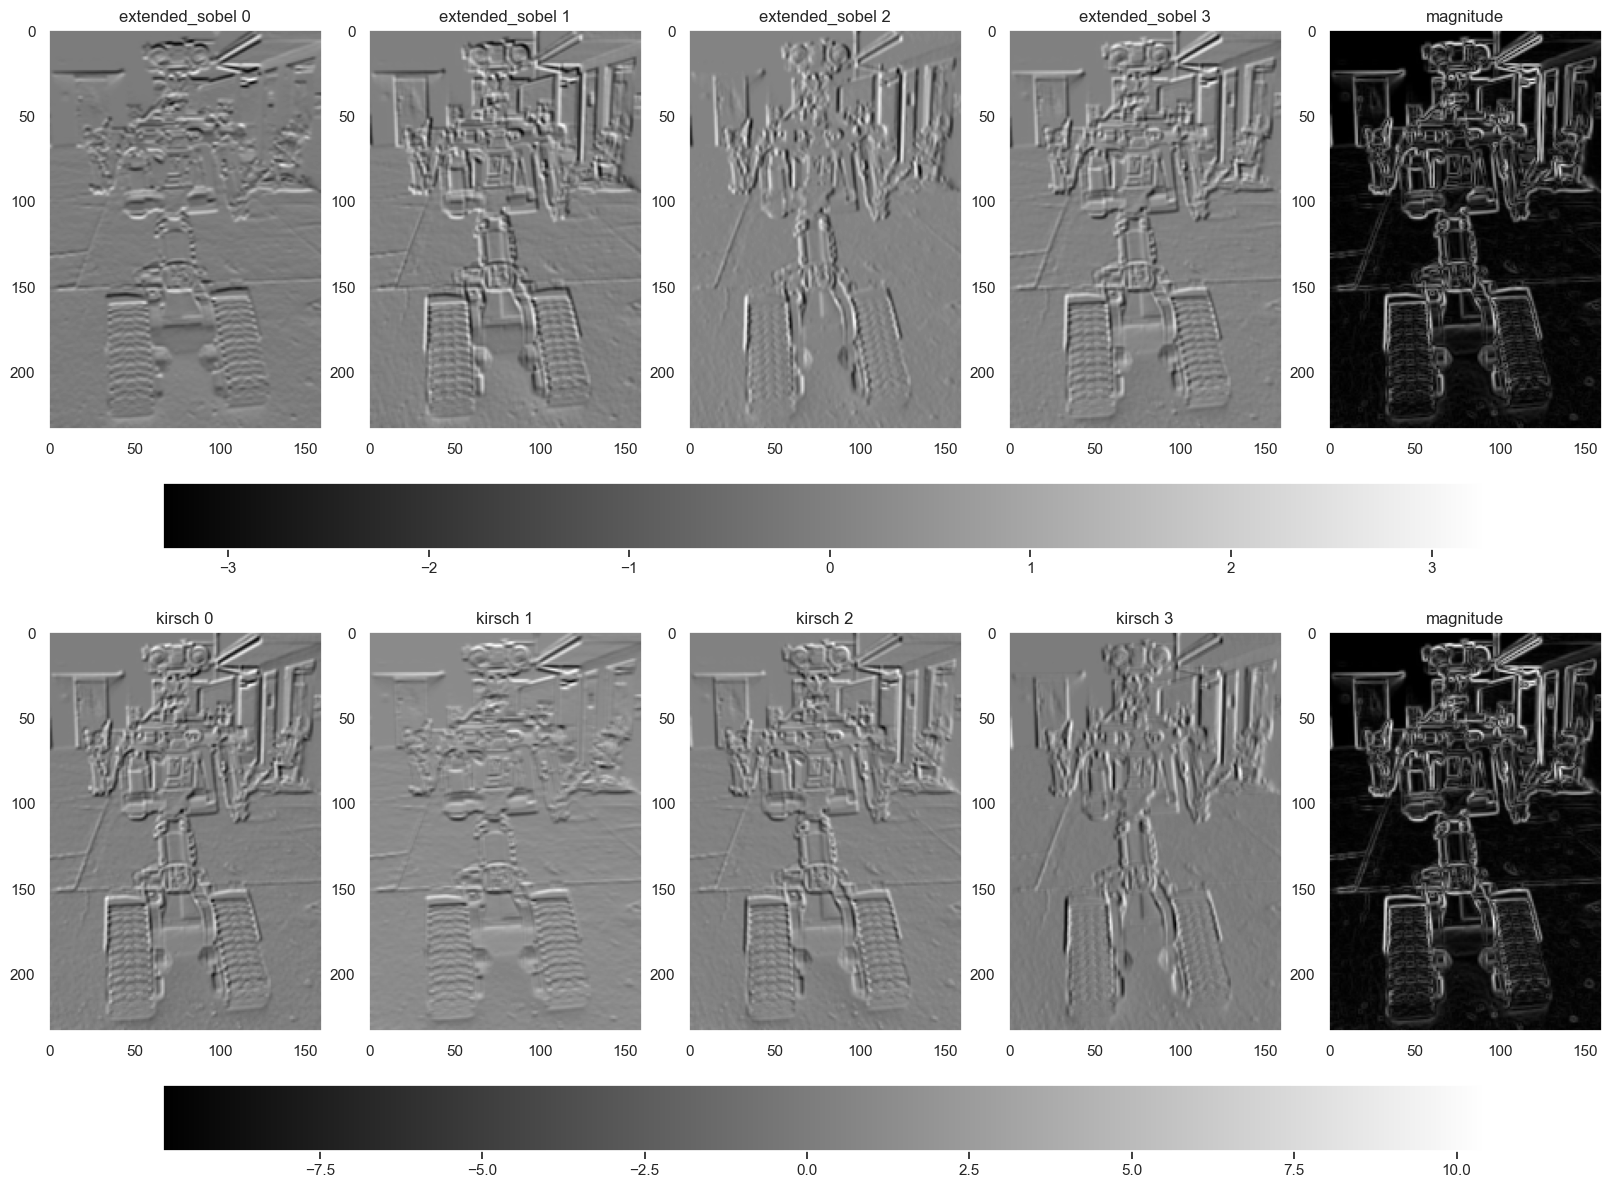

In [34]:
fig, axes = plt.subplots(2, 5, figsize=(16, 12))
for i in range(4):
    ims = axes[0, i].imshow(gray_compass_convs['extended_sobel'][i], cmap='gray')
    axes[0, i].set_title(f"extended_sobel {i}")
    imk = axes[1, i].imshow(gray_compass_convs['kirsch'][i], cmap='gray')
    axes[1, i].set_title(f"kirsch {i}")
axes[0, -1].imshow(gray_compass_convs['extended_sobel'].max(axis=0), cmap='gray')
axes[0, -1].set_title('magnitude')
axes[1, -1].imshow(gray_compass_convs['kirsch'].max(axis=0), cmap='gray');
axes[1, -1].set_title('magnitude');
fig.colorbar(ims, ax=axes[0, :], location='bottom');
fig.colorbar(imk, ax=axes[1, :], location='bottom');

# Edge dection based on second derivatives: Laplacian filter

One problem with gradient-based edge operators based on first derivatives is that each resulting edge is as wide as the underlying intenstiy transition and thus edges might may be poorly localized. Alternative methods that localize edges as zero-crossings of the second derivative try to improve this.

<img src="figures/edges_hough-second_derivative.png" alt="Interpolation" style="width: 6.4in;"/>

Laplace operator is defined as a summation of the second derivatives. In 2D, that is
$$
\nabla^2I(x,y) = I_{xx}(x,y) + I_{yy}(x,y)
$$
where
$$
I_{xx} = \frac{\partial^2I}{\partial x^2}, \qquad I_{yy} = \frac{\partial^2I}{\partial y^2}
$$

Again, since we have discrete images, we'll aproximate the 2nd order derivatives using differences like so:

In [35]:
h_d = np.array([[1, -1]])
h_dd = scipy.signal.convolve2d(h_d, h_d)  # 2nd derivative filter
h_dd

array([[ 1, -2,  1]])

In [36]:
# 2nd derivative in x direction
h_ddx = np.pad(h_dd, ((1, 1), (0, 0)))
h_ddx

array([[ 0,  0,  0],
       [ 1, -2,  1],
       [ 0,  0,  0]])

In [37]:
# 2nd derivative in y direction
h_ddy = h_ddx.T
h_ddy

array([[ 0,  1,  0],
       [ 0, -2,  0],
       [ 0,  1,  0]])

In [38]:
# laplacian filter
h_lap = h_ddx + h_ddy
h_lap

array([[ 0,  1,  0],
       [ 1, -4,  1],
       [ 0,  1,  0]])

There are actually at least four filter versions approximating the Laplacian operator, which depend on how we define image connectivity.

In [39]:
kernels_lap = np.array(
    [
        [0, 1, 0, 1, -4, 1, 0, 1, 0],
        [1, 1, 1, 1, -8, 1, 1, 1, 1],
        [2, -1, 2, -1, -4, -1, 2, -1, 2],
        [-1, 2, -1, 2, -4, 2, -1, 2, -1]
    ],
    dtype=float
).reshape((-1, 3, 3))
kernels_lap

array([[[ 0.,  1.,  0.],
        [ 1., -4.,  1.],
        [ 0.,  1.,  0.]],

       [[ 1.,  1.,  1.],
        [ 1., -8.,  1.],
        [ 1.,  1.,  1.]],

       [[ 2., -1.,  2.],
        [-1., -4., -1.],
        [ 2., -1.,  2.]],

       [[-1.,  2., -1.],
        [ 2., -4.,  2.],
        [-1.,  2., -1.]]])

In [40]:
gray_lap = np.array([
    scipy.ndimage.convolve(gray, kernel)
    for kernel in kernels_lap
])
gray_lap.shape

(4, 234, 160)

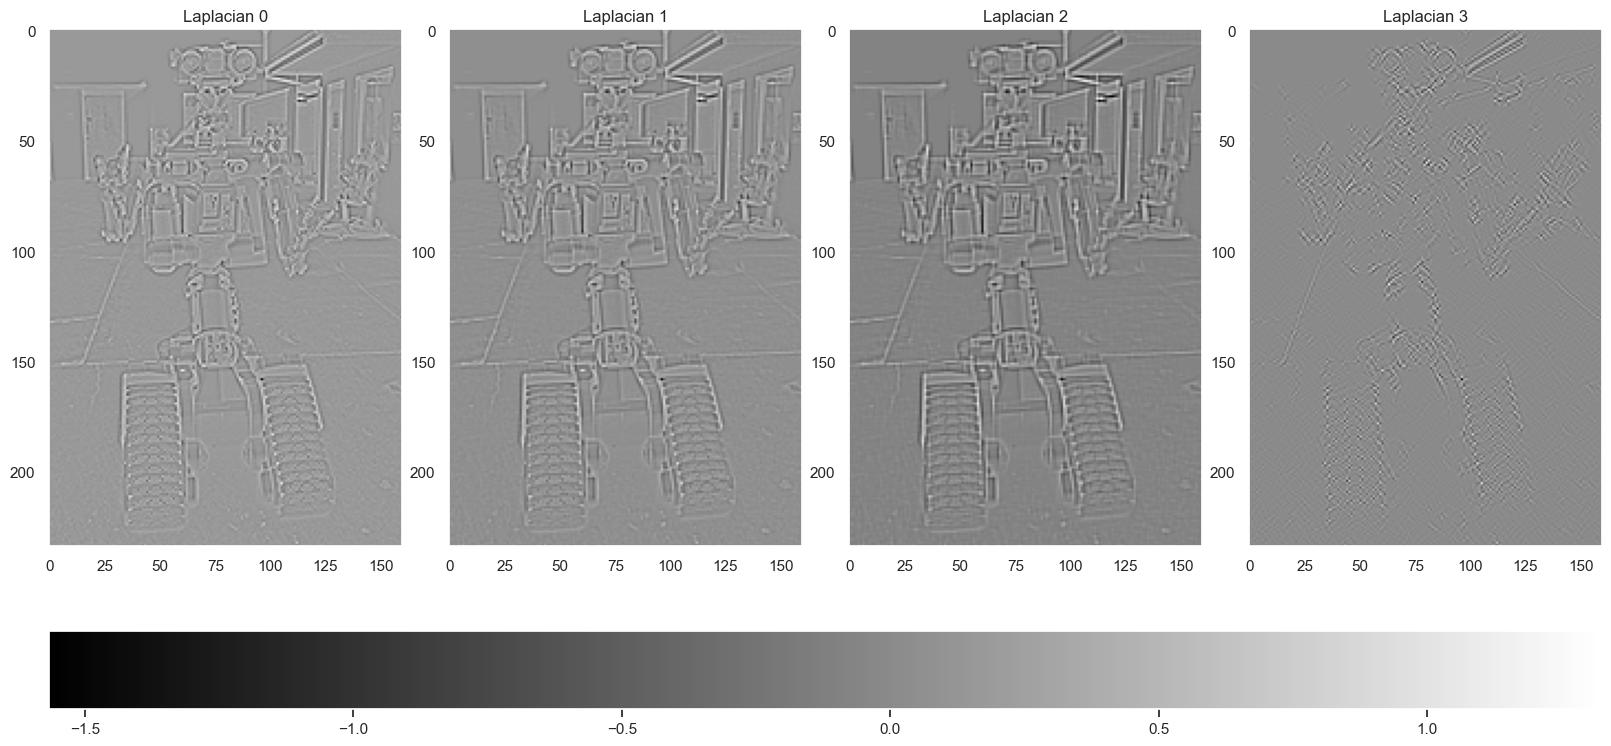

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(16, 12))
for i in range(4):
    ims = axes[i].imshow(gray_lap[i], cmap='gray')
    axes[i].set_title(f"Laplacian {i}")
fig.colorbar(ims, ax=axes, location='bottom');

Location of edges might be detected as zero crossings of the Laplacian responses. However, due to very large number of such crossings, we'll also need to further filter them out by looking at the gradient magnitude at corresponding positions.

In [42]:
def zero_cross_2d(mat: np.ndarray):
    dil = skimage.morphology.binary_dilation(mat > 0)
    return np.logical_and(dil, mat < 0)

In [43]:
gray_lap_edges = np.zeros(gray_lap.shape, dtype=bool)
for i in range(gray_lap.shape[0]):
    gray_lap_edges[i] = zero_cross_2d(gray_lap[i])
    gray_lap_edges[i][gray_grad_mags['improved_sobel'] < 0.1] = False  # filter out weak edges

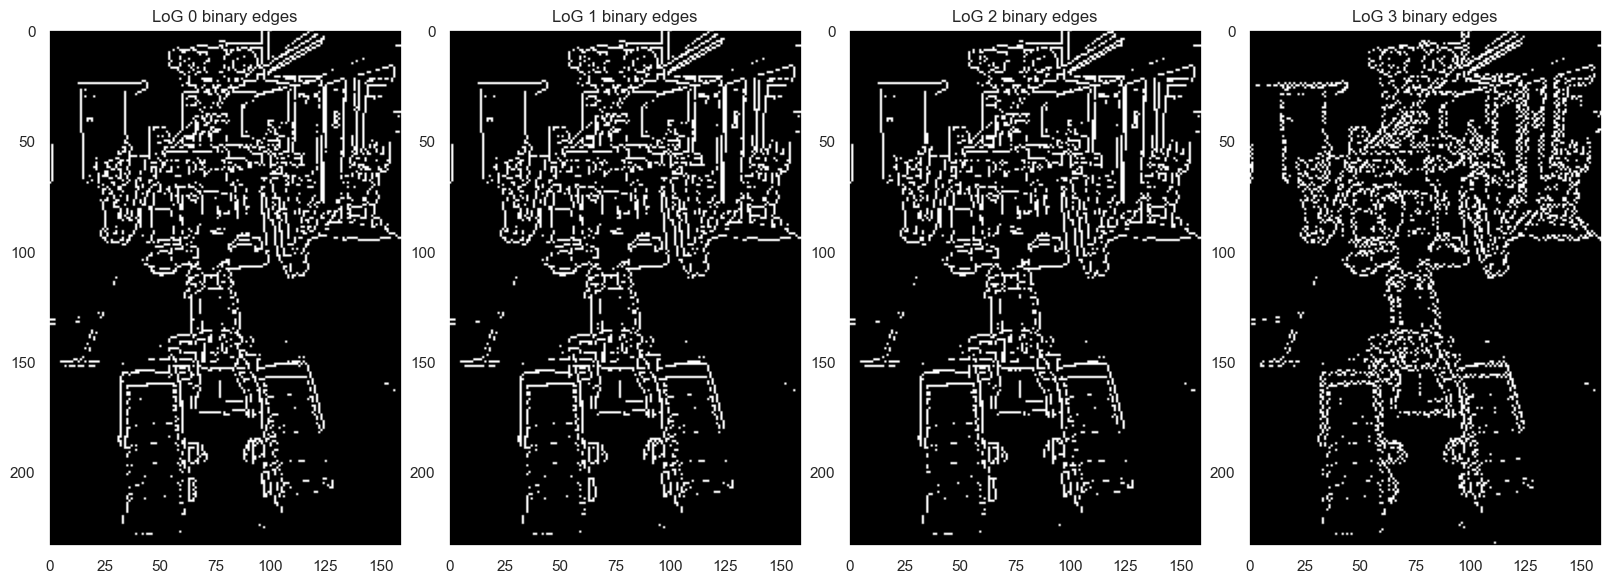

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(16, 12))
for i in range(4):
    ims = axes[i].imshow(gray_lap_edges[i], cmap='gray')
    axes[i].set_title(f"LoG {i} binary edges")

# Edge sharpening

Laplacian operator $\nabla^2$ is useful for image sharpening. Image can be sharpened as
$$
I' = I - \alpha \cdot (I * \nabla^2I)
$$
where
-  $0 \lt \alpha \lt 1$ is a hyper-parameter controlling the amount of sharpening,
-  $*$ denotes convolution.

The following image illustrates the idea of subtracting the 2nd serivative from the original.

<img src="figures/edges_hough-sharpening.png" alt="Interpolation" style="width: 6.4in;"/>

In [45]:
gray_sharps = np.array([
    np.clip(gray - 0.3 * scipy.ndimage.convolve(gray, kernel), 0., 1.)
    for kernel in kernels_lap
])
gray_sharps.shape

(4, 234, 160)

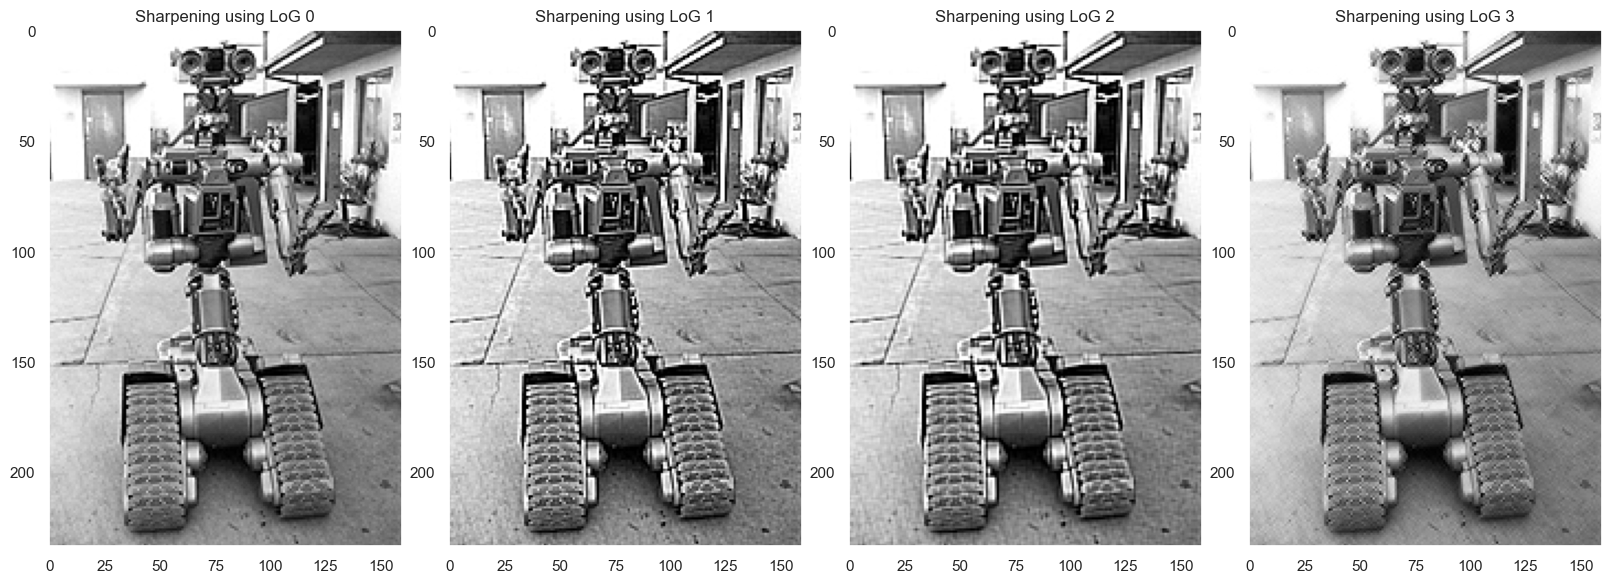

In [46]:
fig, axes = plt.subplots(1, 4, figsize=(16, 12))
for i in range(4):
    ims = axes[i].imshow(gray_sharps[i], cmap='gray', vmin=0, vmax=1)
    axes[i].set_title(f"Sharpening using LoG {i}")

# Unsharp masking

Perhaps surprisingly, image blurring can be used for sharpening as well. This idea is the basis for unsharp masking, see. [Wikipedia](https://en.wikipedia.org/wiki/Unsharp_masking). It works in two steps:
1. A "mask" image $M$ is generated as
   $$
   M = I - (I * h_{\textrm{smooth}})
   $$
   where $h_{\textrm{smooth}}$ is some smoothing filter, typically Gaussian.
2. Sharpened image $I'$ is produced by adding the scaled "mask" image to the original
   $$
   I' = I + \alpha \cdot M
   $$
   where $\alpha \in \mathbb{R}$ is a coefficient controlling the amount of sharpening.

In the below code we compute a negative of the mask and then subtract it from the original to illustrate the similarity with Laplacian edge sharpening.

In [47]:
gray_blur = scipy.ndimage.gaussian_filter(gray, 3.)
gray_dif = gray_blur - gray  # negative of the mask; difference of gaussians approximates laplacian of gaussian
gray_unsharp = np.clip(gray - 0.5 * gray_dif, 0., 1.)

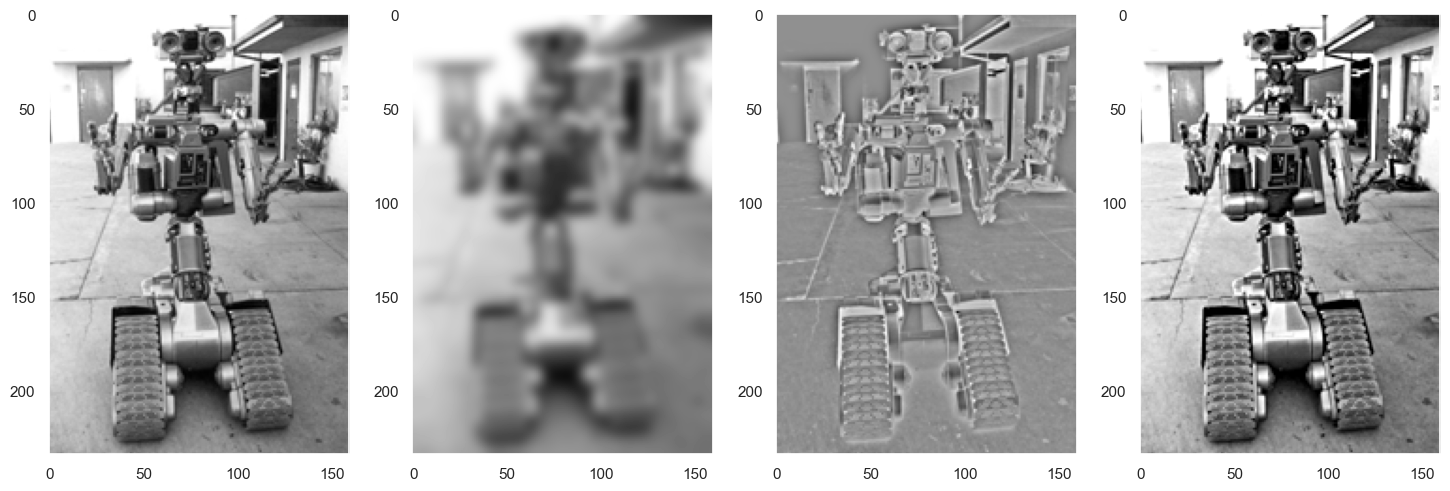

In [48]:
fig, axes = plt.subplots(1, 4, figsize=plt.figaspect(0.33))
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=1);
axes[1].imshow(gray_blur, cmap='gray', vmin=0, vmax=1);
axes[2].imshow(gray_dif, cmap='gray');
axes[3].imshow(gray_unsharp, cmap='gray', vmin=0, vmax=1);

# Canny edge detection

Widely used and still considered state of the art method of edge detection is the Canny edge operator. It has several principal stages:
1. Preprocessing.
   - The image is blurred using a Gaussian filter with some $\sigma$.
2. Gradient computation.
   - Partial derivatives $I_x$ and $I_y$ are typically computed using Sobel kernels.
3. Non-maximum suppression.
   - Only those pixels whose gradient have the highest magnitude than their two immediate neighbors are kept as potential edges.
   - Each pixel is compared to the neighbors lying *in the direction of the gradient*, i.e. perpendicular to the edge, see the following ilustration.
   <figure>
      <img src="figures/edges_hough-canny_nms.png" style="width: 6.4in;"/>
      <figcaption>Figure source: <a href="https://link.springer.com/book/10.1007/978-3-031-05744-1">Digital Image Processing: An Algorithmic Introduction</a></figcaption>
   </figure>
   - In practice, gradient orientations are quantized into 4 bins, i.e. only 4 possible gradient directions are considered.
4. Hysteresis thresholding.
   - Local gradient magnitude maximums that survived the preceeding step are marked as a *"sure" edge*, if their value is higher than some threshold $t_{\textrm{hi}}$.
   - There is, however, a second smaller threshold $t_{\textrm{lo}}$. If a gradient magnitude falls between these two thresholds, i.e. $t_{\textrm{lo}} \le |\nabla I| \le t_{\textrm{hi}}$, it is marked as a *"potential" edge*. "Potential" edge pixels are classified as edges only if they are connected to some "sure" edge pixel.
5. The whole procedure may be repeated for different preprocessing $\sigma$ (scales). The scale-specific results are then merged into a single binary edge image.

In [49]:
def canny_interact(sigma: float = 1., low_threshold: float = 0.2, high_threshold: float = 0.5):
    gray_canny = skimage.feature.canny(gray, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
    plt.imshow(gray_canny, cmap='gray', vmin=0., vmax=1.);

ipywidgets.interact(canny_interact, sigma=(0., 10.), low_threshold=(0., 3.), high_threshold=(0., 3.));

interactive(children=(FloatSlider(value=1.0, description='sigma', max=10.0), FloatSlider(value=0.2, descriptio…

# Hough transform for line detection

Usually, lines are expressed in a **standard form**
$$
a \cdot x + b \cdot y + c = 0
$$
where $a,b,c \in \mathbb{R}$ define the line and every point $(x,y)$ lying on the line satisfies the equation.

However, for better mathematical convenience, Hough transform works with lines in the **polar form**, in which every point $(x,y)$ satisfies
$$
r = x \cdot \cos(\theta) + y \cdot \sin(\theta)
$$
where
- $\theta$ represents line orientation (angle),
- $r$ is a distance from the center of the coordinate system; see the following figure.

<figure>
    <img src="figures/edges_hough-r_theta_line.gif" style="width: 3.2in;"/>
    <figcaption>Figure source: <a href="https://en.wikipedia.org/wiki/Hough_transform">https://en.wikipedia.org/wiki/Hough_transform</a></figcaption>
</figure>

Hough transform then works as a voting scheme, in which every point votes for all lines passing through it. The method proceeds as follows.
1. Initialize a 2D accumulator table $A(\theta,r)$ to zeros. Each entry $(\theta,r)$ in $A$ represents one of the lines that can appear in our image.
2. For each non-zero point $(x,y)$ in our binary image:
   1. For each line angle $\theta_i = 0\degree,\ldots,180\degree$
      1. Calculate
         $$
         r_i = x \cdot \cos(\theta_i) + y \cdot \sin(\theta_i)
         $$
         i.e. distance $r_i$ from the origin of the line with angle $\theta_i$ passing through point $(x,y)$
      2. Vote for computed line $(\theta_i,r_i)$ in the accumulator table:
         $$
         A(\theta_i,r_i) \leftarrow A(\theta_i,r_i) + 1
         $$
3. Find local maximums with sufficient number of votes in the accumulator table $A$. Each such maximum represents one of the detected lines in the image.

For example, in the following figure we see 3 points (black dots) and only consider the angles $\theta_i = 0\degree, 15\degree, 30\degree, 45\degree, 60\degree, 75\degree$.
- Each point votes for 5 lines that pass through it.
- The blue line corresponding to angle $\theta = 60\degree$ and distance $r$ in the interval $[400, 410]$ gets 3 votes, because it is common to all the 3 points.
- All the other lines only get one vote each, because they do not pass through more than one point (they each have different $r$).
<figure>
    <img src="figures/edges_hough-hough_transform_diagram.png" style="width: 6.4in;"/>
    <figcaption>Figure source: <a href="https://en.wikipedia.org/wiki/Hough_transform">https://en.wikipedia.org/wiki/Hough_transform</a></figcaption>
</figure>

In [67]:
rgb = skimage.io.imread('sudoku-alt3.jpg')
rgb = skimage.util.img_as_float(rgb)
rgb = skimage.transform.rescale(rgb, 640 / rgb.shape[1], channel_axis=2)
rgb.shape, rgb.dtype, rgb.min(), rgb.max()

((475, 640, 3), dtype('float64'), 0.0903779382547206, 0.9999999999686231)

In [68]:
gray = skimage.color.rgb2gray(rgb)
gray.shape, gray.dtype, gray.min(), gray.max()

((475, 640), dtype('float64'), 0.09627165574607559, 0.9999999906700534)

In [69]:
edges = skimage.feature.canny(gray, sigma=1., low_threshold=0.3, high_threshold=0.6)
edges.shape, edges.dtype, edges.min(), edges.max()

((475, 640), dtype('bool'), False, True)

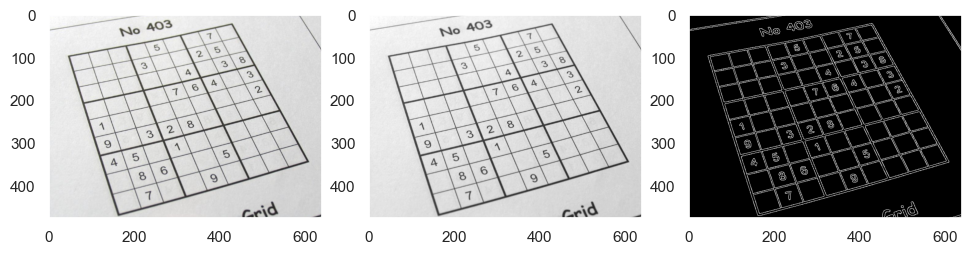

In [70]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.5))
axes[0].imshow(rgb)
axes[1].imshow(gray, cmap='gray', vmin=0., vmax=1.);
axes[2].imshow(edges, cmap='gray', vmin=0., vmax=1.);

## Hough lines in scikit-image

In [71]:
hough_accum, angles, dists = skimage.transform.hough_line(edges)
hough_accum.shape, angles.shape, dists.shape

((1597, 180), (180,), (1597,))

In [72]:
line_num_pts, line_angles, line_dists = skimage.transform.hough_line_peaks(hough_accum, angles, dists)
line_num_pts.shape, line_angles.shape, line_dists.shape

((20,), (20,), (20,))

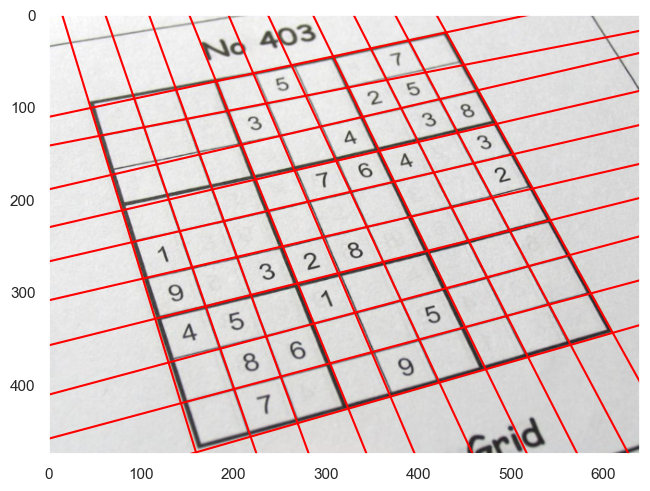

In [73]:
plt.imshow(rgb);
plt.xlim(0, rgb.shape[1])
plt.ylim(rgb.shape[0], 0)
for num_pts, angle, dist in zip(line_num_pts, line_angles, line_dists):
    y1 = dist / np.sin(angle) if angle not in (-np.pi, 0., np.pi) else 1e9
    x2 = dist / np.cos(angle) if angle not in (-np.pi / 2., np.pi / 2.) else 1e9
    plt.axline((0, y1 if not np.isinf(y1) else 1e9), (x2 if not np.isinf(x2) else 1e9, 0), color=(1, 0, 0))

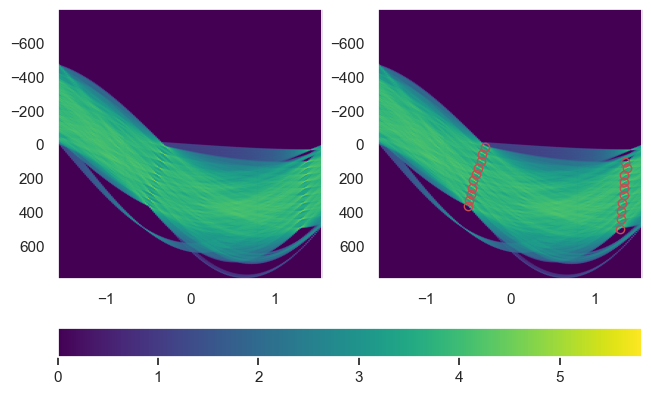

In [74]:
fig, axes = plt.subplots(1, 2)
im1 = axes[0].imshow(np.log(1 + hough_accum), extent=(angles[0], angles[-1], dists[-1], dists[0]))
axes[0].set_aspect(0.002)
im2 = axes[1].imshow(np.log(1 + hough_accum), extent=(angles[0], angles[-1], dists[-1], dists[0]))
axes[1].set_aspect(0.002)
axes[1].plot(line_angles, line_dists, 'or', markerfacecolor='none')
fig.colorbar(im1, ax=axes, location='bottom');

## Hough lines in OpenCV

In [75]:
lines = cv.HoughLines(skimage.util.img_as_ubyte(edges), 1, np.pi/180, 160).squeeze()
lines.shape, lines

((53, 2),
 array([[-331.   ,    2.653],
        [-367.   ,    2.635],
        [-363.   ,    2.635],
        [-179.   ,    2.74 ],
        [-182.   ,    2.74 ],
        [-328.   ,    2.653],
        [-294.   ,    2.67 ],
        [-141.   ,    2.758],
        [ 397.   ,    1.309],
        [-291.   ,    2.67 ],
        ...,
        [ -99.   ,    2.793],
        [ 100.   ,    1.396],
        [ 496.   ,    1.309],
        [ 396.   ,    1.326],
        [-223.   ,    2.723],
        [ 353.   ,    1.309],
        [ 104.   ,    1.396],
        [-299.   ,    2.688],
        [-252.   ,    2.688],
        [-174.   ,    2.723]], dtype=float32))

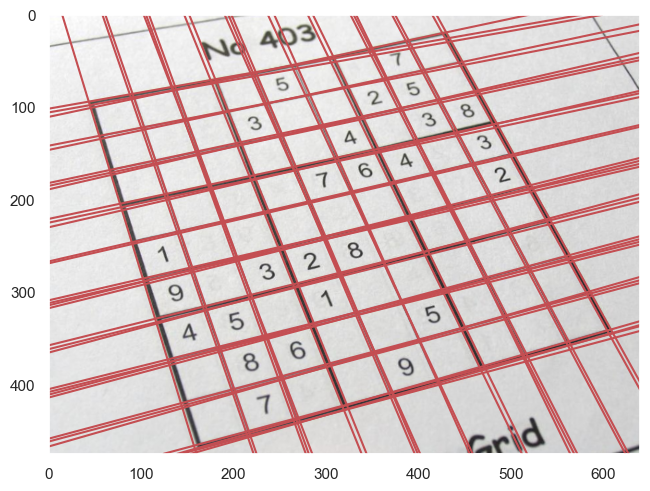

In [76]:
plt.imshow(rgb);
plt.xlim(0, rgb.shape[1])
plt.ylim(rgb.shape[0], 0)
for dist, angle in lines:
    y1 = dist / np.sin(angle) if angle not in (-np.pi, 0., np.pi) else 1e9
    x2 = dist / np.cos(angle) if angle not in (-np.pi / 2., np.pi / 2.) else 1e9
    plt.axline((0, y1 if not np.isinf(y1) else 1e9), (x2 if not np.isinf(x2) else 1e9, 0), color='r')

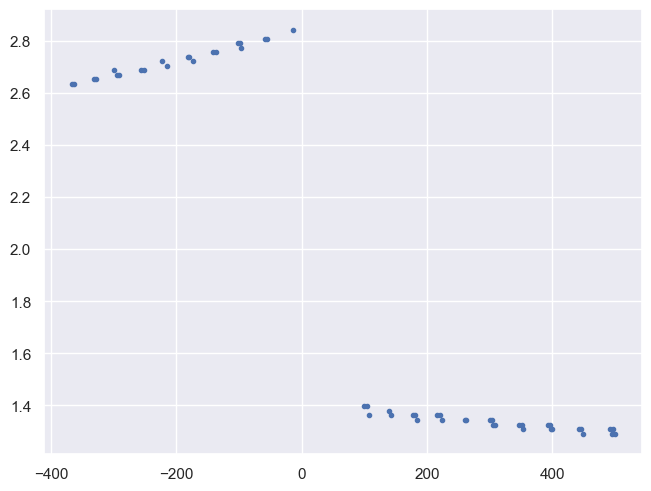

In [77]:
# show the lines as points in 2D parameter space
plt.plot(lines[:, 0], lines[:, 1], '.');
plt.grid();

In [78]:
# axes have different units and so it is difficult to properly calculate Euclidean distance between points --> normalize by the standard deviation
std = np.std(lines, axis=0)
lines_ = lines / std

In [79]:
lines_

array([[-1.196,  3.866],
       [-1.326,  3.841],
       [-1.312,  3.841],
       [-0.647,  3.993],
       [-0.658,  3.993],
       [-1.185,  3.866],
       [-1.062,  3.892],
       [-0.51 ,  4.019],
       [ 1.435,  1.908],
       [-1.052,  3.892],
       ...,
       [-0.358,  4.07 ],
       [ 0.361,  2.035],
       [ 1.792,  1.908],
       [ 1.431,  1.933],
       [-0.806,  3.968],
       [ 1.276,  1.908],
       [ 0.376,  2.035],
       [-1.08 ,  3.917],
       [-0.911,  3.917],
       [-0.629,  3.968]], dtype=float32)

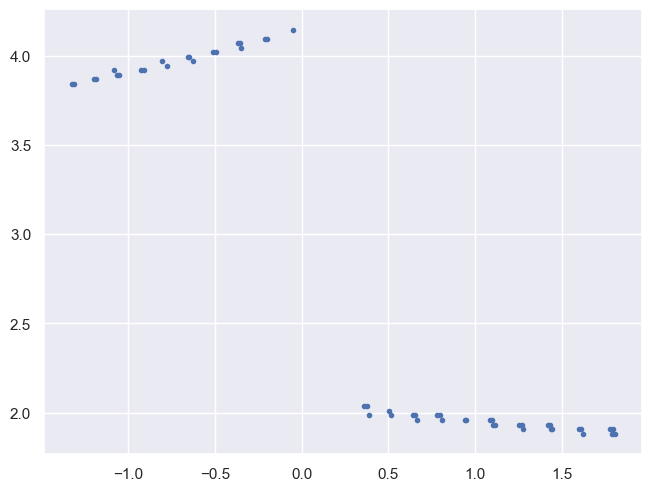

In [80]:
# show the normalized lines as points in 2D parameter space
plt.plot(lines_[:, 0], lines_[:, 1], '.');
plt.grid();

In [81]:
# limitations of kmeans is that we must know the number of clusters beforehand
kmeans = sklearn.cluster.KMeans(n_clusters=20, n_init=100, max_iter=300).fit(lines_)
kmeans.cluster_centers_

C:\Users\ANOOP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[-1.065,  3.9  ],
       [ 0.943,  1.959],
       [-0.358,  4.061],
       [ 1.612,  1.899],
       [ 0.376,  2.018],
       [-0.791,  3.955],
       [ 1.433,  1.92 ],
       [ 0.654,  1.976],
       [-1.191,  3.866],
       [-0.204,  4.095],
       [ 1.1  ,  1.946],
       [ 1.266,  1.925],
       [-0.92 ,  3.917],
       [ 1.79 ,  1.895],
       [ 0.795,  1.976],
       [-0.644,  3.985],
       [-0.5  ,  4.019],
       [-1.319,  3.841],
       [-0.051,  4.146],
       [ 0.51 ,  1.997]], dtype=float32)

In [82]:
# restore the original units
clusters = kmeans.cluster_centers_ * std

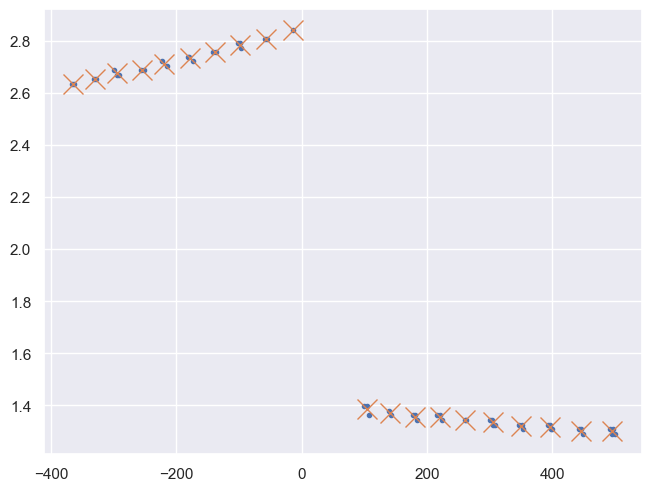

In [83]:
plt.plot(lines[:, 0], lines[:, 1], '.');
plt.plot(clusters[:, 0], clusters[:, 1], 'x', markersize=15);
plt.grid();

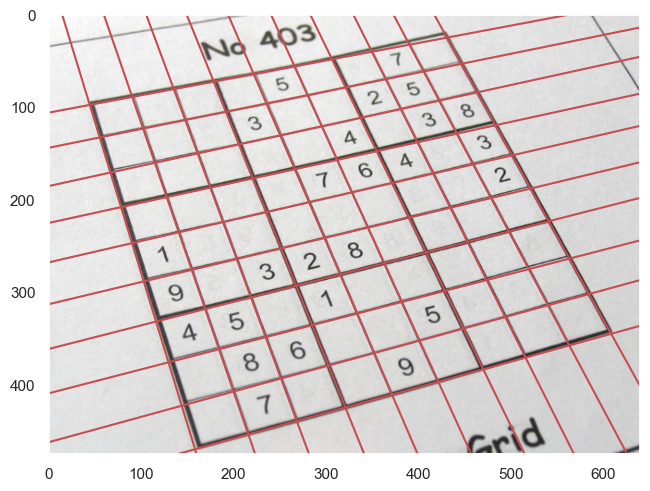

In [84]:
plt.imshow(rgb);
plt.xlim(0, rgb.shape[1])
plt.ylim(rgb.shape[0], 0)
for dist, angle in clusters:
    y1 = dist / np.sin(angle) if angle not in (-np.pi, 0., np.pi) else 1e9
    x2 = dist / np.cos(angle) if angle not in (-np.pi / 2., np.pi / 2.) else 1e9
    plt.axline((0, y1 if not np.isinf(y1) else 1e9), (x2 if not np.isinf(x2) else 1e9, 0), color='r')

# Hough transform for circles

In [85]:
rgb = skimage.io.imread('water_coins.jpg')
rgb = skimage.util.img_as_float(rgb)
gray = skimage.color.rgb2gray(rgb)
edges = skimage.feature.canny(gray, sigma=1., low_threshold=0.3, high_threshold=0.6)


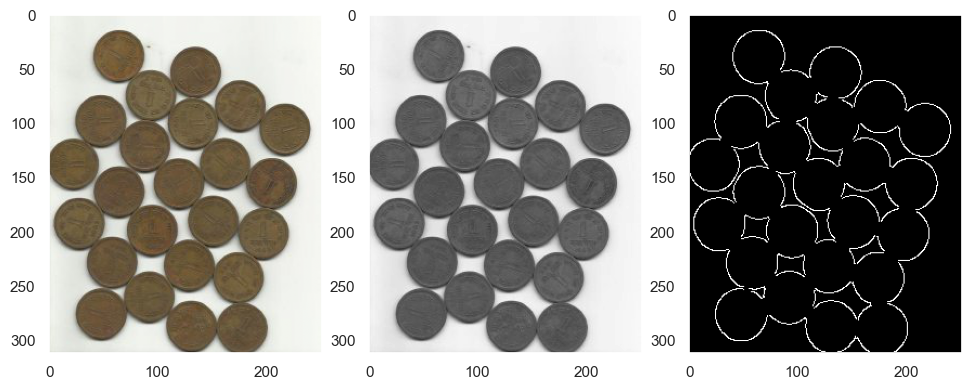

In [86]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.5))
axes[0].imshow(rgb)
axes[1].imshow(gray, cmap='gray', vmin=0., vmax=1.);
axes[2].imshow(edges, cmap='gray', vmin=0., vmax=1.);

In [87]:
radii = np.linspace(20., 30., 20)
hough_circ_accum = skimage.transform.hough_circle(edges, radii, normalize=True)  # normalize is True by default
hough_circ_accum.shape  # accumulator table for each radius

(20, 312, 252)

In [88]:
def hough_circ_accum_interact(radius: float):
    plt.imshow(hough_circ_accum[np.argmin(np.abs(radii - radius))], vmin=0, vmax=0.25);
    plt.colorbar();

ipywidgets.interact(hough_circ_accum_interact, radius=(radii[0], radii[-1]));

interactive(children=(FloatSlider(value=25.0, description='radius', max=30.0, min=20.0), Output()), _dom_class…

In [89]:
hough_circ_acc_vals, hough_circ_cx, hough_circ_cy, hough_circ_radii = skimage.transform.hough_circle_peaks(
    hough_circ_accum,
    radii,
    min_xdistance = 10,
    min_ydistance = 10,
    threshold = 0.5 * hough_circ_accum.max()
)
hough_circ_acc_vals.shape, hough_circ_cx.shape, hough_circ_cy.shape, hough_circ_radii.shape

((24,), (24,), (24,), (24,))

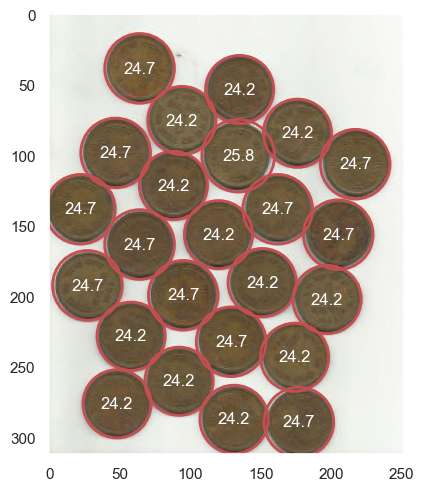

In [90]:
fig, ax = plt.subplots()
ax.imshow(rgb);
for acc_val, cx, cy, rad in zip(hough_circ_acc_vals, hough_circ_cx, hough_circ_cy, hough_circ_radii):
    c = plt.Circle((cx, cy), rad, color='r', linewidth=2, fill=False)
    ax.add_patch(c)
    ax.text(cx, cy, f"{rad:.1f}", color='w', horizontalalignment='center', verticalalignment='center')